In [64]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU # Added GRU for potential use
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Added ReduceLROnPlateau
import math
from datetime import timedelta, datetime

In [65]:
def prepare_lstm_data(df, target_col='Close', sequence_length=60):
    """
    Prepare data for LSTM model by creating sequences

    Parameters:
    df (DataFrame): Input dataframe with features (should have 'date' as index)
    target_col (str): Column to predict
    sequence_length (int): Number of time steps to use for sequences

    Returns:
    tuple: (X_train, y_train, X_test, y_test, scalers, feature_columns, data_for_plotting_index, train_size_after_dropna)
           Returns None for any element if preparation fails.
    """
    print("\n==== Preparing Data for LSTM Model ====")

    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index.")
        return None, None, None, None, None, None, None, None

    # Use the globally defined list of features
    # Ensure all selected features exist in the dataframe
    feature_columns = [col for col in FEATURES_TO_USE if col in df.columns]

    # Ensure the target column is always included in the features list
    if target_col not in feature_columns:
        if target_col in df.columns:
            feature_columns.append(target_col) # Add it if it exists in df but not in FEATURES_TO_USE
        else:
            print(f"Error: Target column '{target_col}' not found in the DataFrame.")
            return None, None, None, None, None, None, None, None

    # Check for any specified features that are missing from the DataFrame
    missing_features = [col for col in FEATURES_TO_USE if col not in df.columns]
    if missing_features:
        print(f"Warning: The following specified features are missing from the DataFrame: {missing_features}")
        # The feature_columns list already excludes these, so no further action needed here

    if not feature_columns:
        print("Error: No valid features selected or found in the DataFrame. Exiting data preparation.")
        return None, None, None, None, None, None, None, None

    print(f"Using {len(feature_columns)} features: {feature_columns[:10]}{'...' if len(feature_columns) > 10 else ''}")

    # Create a new dataframe with selected features, dropping NaN rows
    # Only drop NaNs based on the selected feature columns
    data = df[feature_columns].dropna()
    data_for_plotting_index = data.index # Store index of the data *after* dropping NaNs for accurate plotting

    # Check if enough data remains after dropping NaNs
    if len(data) < sequence_length + 1: # Need at least one sequence plus one target value
        print(f"Error: Not enough data ({len(data)} rows) after dropping NaNs to create sequences of length {sequence_length}.")
        return None, None, None, None, None, None, None, None

    # Split into training and test sets (70% train, 30% test) based on the cleaned data length
    train_size_after_dropna = int(len(data) * 0.7)
    train_data = data.iloc[:train_size_after_dropna]
    test_data = data.iloc[train_size_after_dropna:]

    # Check if train/test sets are large enough to create at least one sequence
    if len(train_data) < sequence_length or len(test_data) < sequence_length: # Min 1 sequence needed from each
        print(f"Error: Not enough data in train ({len(train_data)}) or test ({len(test_data)}) set after splitting to create sequences of length {sequence_length}.")
        return None, None, None, None, None, None, None, None

    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")

    # Normalize the data - store scalers for later inverse transformation
    scalers = {}
    train_scaled = pd.DataFrame(index=train_data.index) # Preserve index
    test_scaled = pd.DataFrame(index=test_data.index) # Preserve index

    for column in feature_columns: # Iterate over the actual columns being used
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Fit scaler on training data
        train_scaled[column] = scaler.fit_transform(train_data[column].values.reshape(-1, 1)).flatten()
        # Transform test data with the same scaler
        test_scaled[column] = scaler.transform(test_data[column].values.reshape(-1, 1)).flatten()
        # Store scaler for inverse transformation later
        scalers[column] = scaler

    # Create sequences for LSTM
    def create_sequences(data_df, seq_length): # Pass DataFrame to easily get target_idx
        X, y = [], []
        # Use .values to work with numpy arrays for sequence creation
        data_values = data_df.values
        # Find the index of the target column in the current data_values array
        # This is important because the order of columns in 'data_df.columns' matches data_values
        try:
            target_idx_in_values = data_df.columns.get_loc(target_col)
        except KeyError:
            print(f"Error: Target column '{target_col}' not found in the DataFrame slice used for sequence creation.")
            return np.array([]), np.array([]) # Return empty arrays on error

        for i in range(len(data_values) - seq_length):
            # Extract sequence of features (from i up to i + seq_length - 1)
            seq_x = data_values[i:(i + seq_length)]
            # Extract target (the target value at the end of the sequence + 1, i.e., at index i + seq_length)
            seq_y = data_values[i + seq_length, target_idx_in_values] # Get target from the next time step
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    # Generate training sequences
    X_train, y_train = create_sequences(train_scaled, sequence_length)
    # Generate test sequences
    X_test, y_test = create_sequences(test_scaled, sequence_length)

    # Check if sequences were created successfully
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Error: Sequence creation failed. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        return None, None, None, None, None, None, None, None

    print(f"Training sequences shape: {X_train.shape}") # Should be (num_samples, sequence_length, num_features)
    print(f"Test sequences shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test, scalers, feature_columns, data_for_plotting_index, train_size_after_dropna


In [66]:
# %%
def train_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Build and train the LSTM model.

    Parameters:
    X_train, y_train: Training data and labels
    X_test, y_test: Validation data and labels
    epochs (int): Number of training epochs
    batch_size (int): Batch size for training

    Returns:
    tuple: (trained_model, history)
    """
    print("\n==== Training LSTM Model ====")
    if X_train.shape[0] == 0:
        print("Error: X_train is empty. Cannot train model.")
        return None, None
        
    sequence_length = X_train.shape[1] # Time steps
    num_features = X_train.shape[2]    # Number of features per time step

    model = Sequential()
    # First LSTM layer
    # units: Dimensionality of the output space (and internal hidden state)
    # return_sequences=True: Return the full sequence to be passed to the next LSTM layer
    # input_shape: (time_steps, num_features)
    model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(0.25)) # Dropout for regularization

    # Second LSTM layer
    model.add(LSTM(75, return_sequences=True))
    model.add(Dropout(0.25))

    # Third LSTM layer
    # return_sequences=False (default): Only return the last output in the output sequence
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.25))

    # Dense layer for further processing before the final output
    model.add(Dense(30, activation='relu')) 
    # model.add(Dropout(0.2)) # Optional dropout after dense layer

    # Output layer: Predicts a single value (the target column for the next time step)
    model.add(Dense(1)) 

    # Compile the model
    # Optimizer: Adam is a common choice
    # Loss function: Mean Squared Error is typical for regression tasks
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Can tune learning_rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print model summary
    model.summary()

    # Callbacks for more robust training
    # EarlyStopping: Stop training when a monitored metric has stopped improving
    # monitor='val_loss': Metric to be monitored (validation loss)
    # patience: Number of epochs with no improvement after which training will be stopped
    # restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored metric.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
    # factor: Factor by which the learning rate will be reduced. new_lr = lr * factor
    # min_lr: Lower bound on the learning rate.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test), # Data on which to evaluate the loss and any model metrics at the end of each epoch
                        callbacks=[early_stopping, reduce_lr], # List of callbacks to apply during training
                        verbose=1) # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
    
    print("Model training complete.")
    return model, history

In [67]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scalers, target_col='Close'):
    """
    Evaluate the LSTM model performance.
    """
    print("\n==== Evaluating Model Performance ====")

    if model is None:
        print("Error: Model is not trained. Cannot evaluate.")
        return None, None, None

    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found.")
        return None, None, None
    scaler = scalers[target_col] # Get the specific scaler for the target column

    # Make predictions on training and test sets
    train_predictions_scaled = model.predict(X_train)
    test_predictions_scaled = model.predict(X_test)

    # Inverse transform predictions to original scale
    train_predictions = scaler.inverse_transform(train_predictions_scaled)
    test_predictions = scaler.inverse_transform(test_predictions_scaled)

    # Inverse transform actual values (y_train, y_test) to original scale for comparison
    # y_train and y_test are 1D, so reshape them to 2D for inverse_transform
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Ensure shapes match before calculating metrics (as in original code)
    # This can happen if sequence creation leads to slightly different numbers of samples
    if y_train_orig.shape[0] != train_predictions.shape[0]:
        print(f"Warning: Train actual ({y_train_orig.shape}) and prediction ({train_predictions.shape}) shapes mismatch. Truncating.")
        min_len_train = min(y_train_orig.shape[0], train_predictions.shape[0])
        y_train_orig = y_train_orig[:min_len_train]
        train_predictions = train_predictions[:min_len_train]

    if y_test_orig.shape[0] != test_predictions.shape[0]:
        print(f"Warning: Test actual ({y_test_orig.shape}) and prediction ({test_predictions.shape}) shapes mismatch. Truncating.")
        min_len_test = min(y_test_orig.shape[0], test_predictions.shape[0])
        y_test_orig = y_test_orig[:min_len_test]
        test_predictions = test_predictions[:min_len_test]

    # Calculate metrics
    metrics = {
        'train_rmse': math.sqrt(mean_squared_error(y_train_orig, train_predictions)),
        'test_rmse': math.sqrt(mean_squared_error(y_test_orig, test_predictions)),
        'train_mae': mean_absolute_error(y_train_orig, train_predictions),
        'test_mae': mean_absolute_error(y_test_orig, test_predictions),
        'train_r2': r2_score(y_train_orig, train_predictions),
        'test_r2': r2_score(y_test_orig, test_predictions)
    }

    # Print metrics
    print(f"Training RMSE: {metrics['train_rmse']:.2f}, Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Training MAE: {metrics['train_mae']:.2f}, Test MAE: {metrics['test_mae']:.2f}")
    print(f"Training R²: {metrics['train_r2']:.4f}, Test R²: {metrics['test_r2']:.4f}")

    return train_predictions, test_predictions, metrics

In [68]:
def visualize_predictions(df_original, train_predictions, test_predictions,
                          data_for_plotting_index, train_size_after_dropna, 
                          future_predictions=None, future_dates=None,
                          sequence_length=60, target_col='Close', history=None):
    """
    Visualize model predictions against actual prices, including future predictions.
    Uses df_original for the full historical actual data.
    Uses data_for_plotting_index and train_size_after_dropna to correctly align predictions.
    """
    print("\n==== Visualizing Predictions ====")

    if not isinstance(df_original.index, pd.DatetimeIndex):
        print("Error: Original DataFrame index is not a DatetimeIndex. Cannot visualize.")
        return
    if data_for_plotting_index is None:
        print("Error: data_for_plotting_index is None. Cannot determine plot dates accurately.")
        return

    plt.figure(figsize=(18, 9)) # Wider plot for better readability

    # Plot actual historical data (from the original unfiltered DataFrame)
    plt.plot(df_original.index, df_original[target_col], color='dodgerblue', label=f'Actual {target_col} Price', alpha=0.7)

    # --- Plotting Training Predictions ---
    # Training predictions correspond to the target values from y_train.
    # y_train values start after the first 'sequence_length' period of the training data.
    # The dates for y_train (and thus train_predictions) are from 
    # data_for_plotting_index[sequence_length] up to data_for_plotting_index[train_size_after_dropna - 1]
    if train_predictions is not None and len(train_predictions) > 0:
        # The number of training predictions should match len(y_train)
        # The dates for these predictions start from the (sequence_length)-th day in the data_for_plotting_index
        # and go up to (train_size_after_dropna - 1)-th day.
        num_train_preds = len(train_predictions)
        train_pred_dates = data_for_plotting_index[sequence_length : sequence_length + num_train_preds]
        
        if len(train_pred_dates) == num_train_preds: # Check if slicing produced correct number of dates
            plt.plot(train_pred_dates, train_predictions.flatten(),
                     color='limegreen', label='Training Predictions', linewidth=1.5)
        else:
            print(f"Warning: Mismatch in length for training prediction dates ({len(train_pred_dates)}) and predictions ({num_train_preds}). Skipping train plot.")


    # --- Plotting Test Predictions ---
    # Test predictions correspond to y_test.
    # y_test values start after the first 'sequence_length' period of the test data.
    # The test data itself starts at index 'train_size_after_dropna' in 'data_for_plotting_index'.
    # So, the first y_test value corresponds to data_for_plotting_index[train_size_after_dropna + sequence_length].
    if test_predictions is not None and len(test_predictions) > 0:
        num_test_preds = len(test_predictions)
        test_pred_start_date_idx = train_size_after_dropna + sequence_length
        
        # Ensure we don't go out of bounds for data_for_plotting_index
        if test_pred_start_date_idx + num_test_preds <= len(data_for_plotting_index):
            test_pred_dates = data_for_plotting_index[test_pred_start_date_idx : test_pred_start_date_idx + num_test_preds]
            if len(test_pred_dates) == num_test_preds: # Check slice
                 plt.plot(test_pred_dates, test_predictions.flatten(),
                         color='orangered', label='Test Predictions', linewidth=1.5)
            else:
                print(f"Warning: Mismatch in length for test prediction dates ({len(test_pred_dates)}) and predictions ({num_test_preds}). Skipping test plot.")
        else:
            print(f"Warning: Not enough dates in data_for_plotting_index for test predictions. Required: {test_pred_start_date_idx + num_test_preds}, Available: {len(data_for_plotting_index)}")


    # Plot future predictions if available
    if future_predictions is not None and future_dates is not None and len(future_dates) > 0 and len(future_predictions) > 0:
        plt.plot(future_dates, future_predictions.flatten(), color='darkviolet', linestyle='--', linewidth=2,
                 label='Future Predictions')

    plt.title(f'{GLOBAL_STOCK_TICKER} - {target_col} Price Prediction', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{target_col} Price ($)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) # Auto locator for better date spacing
    plt.gcf().autofmt_xdate() # Auto-rotate date labels

    plt.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.savefig(f'{GLOBAL_STOCK_TICKER}_stock_prediction_with_future.png')
    plt.show()

    # Plot loss during training if history is available
    if history is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='deepskyblue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
        plt.title(f'{GLOBAL_STOCK_TICKER} - Model Loss During Training', fontsize=16)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'{GLOBAL_STOCK_TICKER}_training_loss.png')
        plt.show()


In [69]:
def predict_future(model, df_original, scalers, feature_columns, target_col='Close', sequence_length=60, days_to_predict=365):
    """
    Predict future values using the trained LSTM model.
    df_original: The original dataframe (before any processing specific to train/test splits for LSTM).
    scalers: Dictionary of scalers for each feature.
    feature_columns: List of feature column names used in the model.
    """
    print(f"\n==== Predicting {days_to_predict} Days into the Future for {GLOBAL_STOCK_TICKER} ====")
    if model is None:
        print("Error: Model is not trained. Cannot predict future.")
        return None, None

    # We need the last 'sequence_length' days of data to start the prediction process.
    # This data should be processed (NaNs dropped for the relevant features) and scaled just like the training data.
    
    # 1. Get the relevant columns from the original dataframe and drop NaNs
    #    This ensures we are using the same feature set that the model was trained on.
    data_for_future_base = df_original[feature_columns].dropna()
    
    if len(data_for_future_base) < sequence_length:
        print(f"Error: Not enough historical data ({len(data_for_future_base)} rows after NaN drop) to form an initial sequence of length {sequence_length} for future prediction.")
        return None, None

    # 2. Get the last 'sequence_length' records from this cleaned data (unscaled at this point)
    #    This will be our initial input sequence to the model, after scaling.
    last_sequence_actual_df = data_for_future_base.tail(sequence_length).copy()

    # 3. Scale this initial sequence using the saved scalers
    current_sequence_scaled_list = []
    for col_name in feature_columns: # Iterate in the order of feature_columns
        if col_name in scalers:
            # Reshape because scaler expects 2D array
            scaled_col_data = scalers[col_name].transform(last_sequence_actual_df[col_name].values.reshape(-1, 1)).flatten()
            current_sequence_scaled_list.append(scaled_col_data)
        else:
            # This should ideally not happen if all features used for training have scalers
            print(f"Warning: Scaler for column '{col_name}' not found during future prediction preparation. Using unscaled values (this may lead to errors).")
            current_sequence_scaled_list.append(last_sequence_actual_df[col_name].values.flatten())
    
    # Transpose to get shape (sequence_length, num_features)
    current_sequence_scaled = np.array(current_sequence_scaled_list).T 

    # Get target scaler for inverse transforming predictions
    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found for inverse transformation.")
        return None, None
    target_scaler = scalers[target_col]

    # Find the index of the target column in the feature_columns list
    try:
        target_idx_in_features = feature_columns.index(target_col)
    except ValueError:
        print(f"Error: Target column '{target_col}' not found in feature_columns list: {feature_columns}")
        return None, None

    future_predictions_unscaled = [] # Store unscaled (actual price) predictions
    
    # Maintain a rolling window of the target prices (actual past prices + new unscaled predictions)
    # This is crucial if you need to recalculate features like MAs based on new predictions.
    # Initialize with the target column from the last actual sequence (unscaled)
    rolling_target_prices = list(last_sequence_actual_df[target_col].values) 

    # Generate future dates
    last_date_in_data = df_original.index[-1] # Use the last date from the original full dataset
    future_dates = [last_date_in_data + timedelta(days=i + 1) for i in range(days_to_predict)]

    # Iteratively predict future values
    for i in range(days_to_predict):
        # Reshape current_sequence_scaled for LSTM model (1 sample, sequence_length time steps, num_features features)
        X_pred = current_sequence_scaled.reshape(1, sequence_length, len(feature_columns))

        # Predict the next day's target value (scaled)
        next_day_target_scaled = model.predict(X_pred, verbose=0) # Verbose=0 to reduce console output

        # Inverse transform the predicted target value to its original scale
        next_day_target_unscaled = target_scaler.inverse_transform(next_day_target_scaled)[0, 0]
        future_predictions_unscaled.append(next_day_target_unscaled)
        
        # Add the new unscaled prediction to our rolling window of target prices
        rolling_target_prices.append(next_day_target_unscaled)

        # --- Prepare the input features for the *next* prediction step ---
        # This is the most complex part for multi-step forecasting.
        # The new row must have all features the model expects.
        new_row_scaled_values = np.zeros(len(feature_columns))
        
        for j, col_name in enumerate(feature_columns):
            if col_name == target_col:
                # For the target column, use the scaled prediction we just made
                new_row_scaled_values[j] = next_day_target_scaled[0, 0]
            # --- CRITICAL IMPROVEMENT AREA for non-target features ---
            elif col_name in ['MA_50', 'MA_200', 'RSI', 'volatility_20d']: # Example technical indicators
                # Ideally, recalculate these based on 'rolling_target_prices'
                # For MA_50, you'd take the last 50 values from rolling_target_prices, calculate MA, then scale it.
                # This requires helper functions to calculate each indicator.
                # Placeholder: Carry forward the last known scaled value. This is a simplification.
                # Example of how one might update MA_50 (conceptual):
                # if col_name == 'MA_50' and len(rolling_target_prices) >= 50:
                #     new_ma50_unscaled = np.mean(rolling_target_prices[-50:])
                #     new_row_scaled_values[j] = scalers[col_name].transform([[new_ma50_unscaled]])[0,0]
                # else: # Not enough data or not MA_50, carry forward
                #     new_row_scaled_values[j] = current_sequence_scaled[-1, j] 
                new_row_scaled_values[j] = current_sequence_scaled[-1, j] # Simplified: carry forward
                if i == 0 and j == feature_columns.index(col_name): # Print warning only once per such feature
                     print(f"Warning: Feature '{col_name}' is using carry-forward logic in predict_future. "
                           "For better accuracy, implement dynamic recalculation based on predicted target.")
            elif col_name in ['Open', 'High', 'Low'] and target_col == 'Close':
                # If predicting 'Close', other OHLC values for the future step need estimation.
                # Simplistic: Open_t+1 = Close_t (previous day's actual/predicted close, scaled)
                # High_t+1, Low_t+1 could be based on predicted Close_t+1 +/- some volatility or set to predicted Close_t+1.
                # Placeholder: Carry forward.
                # Example for Open (conceptual):
                # if col_name == 'Open': # Assume Open_t+1 is based on Close_t
                #    # previous_close_scaled was next_day_target_scaled if current_sequence_scaled[-1, target_idx_in_features] was prev_target
                #    # This needs careful indexing of rolling_target_prices
                #    # For simplicity, if Open is a feature, it's often better to predict it or use a simpler model.
                #    new_row_scaled_values[j] = next_day_target_scaled[0,0] # Simplistic: assume Open for next day is same as predicted Close
                new_row_scaled_values[j] = current_sequence_scaled[-1, j] # Simplified: carry forward
            else:
                # For fundamental features (revenue, eps) or other exogenous variables,
                # carry-forward is often the only option unless you have separate forecasts for them.
                new_row_scaled_values[j] = current_sequence_scaled[-1, j] # Carry forward

        # Update the current_sequence_scaled: remove the oldest row and append the new_row_scaled_values
        current_sequence_scaled = np.vstack([current_sequence_scaled[1:], new_row_scaled_values])

    # Convert future predictions list to numpy array
    future_predictions_unscaled = np.array(future_predictions_unscaled).reshape(-1, 1)

    # Create a dataframe with future predictions and dates
    future_df = pd.DataFrame({
        f'Predicted_{target_col}': future_predictions_unscaled.flatten()
    }, index=pd.to_datetime(future_dates)) # Ensure future_dates are datetime objects for index
    future_df.index.name = 'Date'


    # Save future predictions to CSV
    output_filename = f'{GLOBAL_STOCK_TICKER}_future_predictions.csv'
    try:
        future_df.to_csv(output_filename)
        print(f"Future predictions saved to '{output_filename}'")
    except Exception as e:
        print(f"Error saving future predictions to {output_filename}: {e}")

    return future_predictions_unscaled, future_dates


In [70]:
def predict_lstm(df, target_col='Close', sequence_length=60, epochs=50, batch_size=32, predict_days=365):
    """
    Main function to run LSTM prediction on stock data and predict future values.
    df: The original DataFrame, expected to have a DatetimeIndex named 'date'.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index.")
        return None, None, None, None, None

    # Prepare data: This returns X_train, y_train, X_test, y_test, scalers, feature_columns,
    # data_for_plotting_index, and train_size_after_dropna
    prepared_data = prepare_lstm_data(
        df, target_col=target_col, sequence_length=sequence_length
    )

    # Unpack prepared data
    if prepared_data is None or prepared_data[0] is None: # Check if X_train is None (indicates failure)
        print("Data preparation failed. Exiting prediction process.")
        return None, None, None, None, None
    
    X_train, y_train, X_test, y_test, scalers, feature_columns, \
    data_for_plotting_index, train_size_after_dropna = prepared_data

    # Train LSTM model
    model, history = train_lstm_model(
        X_train, y_train, X_test, y_test,
        epochs=epochs, batch_size=batch_size
    )

    if model is None:
        print("Model training failed. Exiting prediction process.")
        return None, None, None, None, None

    # Evaluate model
    train_predictions, test_predictions, metrics = evaluate_model(
        model, X_train, y_train, X_test, y_test, scalers, target_col
    )

    # Note: Even if evaluation has issues (e.g., metrics is None), we might still want to proceed
    # to future prediction and visualization if the model itself trained.
    if metrics is None:
        print("Model evaluation encountered an issue, but proceeding with future prediction if possible.")
        # Depending on strictness, you might choose to return here.

    # Predict future values
    # Pass the original DataFrame 'df' to predict_future for accessing the latest actual data
    future_predictions, future_dates = predict_future(
        model, df, scalers, feature_columns, 
        target_col=target_col, sequence_length=sequence_length, days_to_predict=predict_days
    )

    # Visualize results including future predictions
    # Pass the original DataFrame 'df' for plotting actuals, and helper indices for aligning predictions
    visualize_predictions(
        df, train_predictions, test_predictions,
        data_for_plotting_index, train_size_after_dropna, # These help align train/test preds with dates
        future_predictions, future_dates,
        sequence_length, target_col, history
    )

    # Save the trained model
    # Using .keras format is preferred for TensorFlow models
    model_filename = f'{GLOBAL_STOCK_TICKER}_lstm_model.keras' 
    try:
        model.save(model_filename)
        print(f"Model saved as '{model_filename}'")
    except Exception as e:
        print(f"Error saving model to {model_filename}: {e}")

    # Create a combined dataset with historical actuals and future predictions
    historical_actual = df[[target_col]].copy()
    historical_actual.columns = [f'Actual_{target_col}'] # Rename for clarity

    if future_predictions is not None and future_dates is not None:
        future_df = pd.DataFrame({
            f'Predicted_{target_col}': future_predictions.flatten()
        }, index=pd.to_datetime(future_dates)) # Ensure index is datetime
        future_df.index.name = 'Date'


        # Combine historical and future data
        combined_df = pd.concat([historical_actual, future_df]) # Concatenates along rows by default
        combined_output_filename = f'{GLOBAL_STOCK_TICKER}_historical_and_future.csv'
        try:
            combined_df.to_csv(combined_output_filename)
            print(f"Combined historical and future predictions saved to '{combined_output_filename}'")
        except Exception as e:
            print(f"Error saving combined data to {combined_output_filename}: {e}")
    else:
        print("Skipping saving combined historical and future data due to failed future prediction.")
        # combined_df = historical_actual # In this case, only historical data is available

    return model, metrics, test_predictions, future_predictions, future_dates

Attempting to load processed data for LSTM prediction from: NVDA_merged_dataset_NVDA.csv
Data loaded successfully. Shape: (1333, 40)
Columns available: ['calendarYear', 'period', 'revenue', 'grossProfit', 'netIncome', 'operatingIncome', 'eps', 'epsdiluted', 'researchAndDevelopmentExpenses', 'operatingExpenses', 'grossProfitRatio', 'operatingIncomeRatio', 'netIncomeRatio', 'weightedAverageShsOutDil', 'Close', 'High', 'Low', 'Open', 'Volume', 'days_since_financial_update', 'price_change_pct', 'price_change', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'RSI', 'returns', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'PE_ratio', 'volume_change', 'volume_ma_5', 'momentum_5d', 'momentum_10d', 'momentum_20d', 'market_cap', 'price_to_sales']
Date range: 2020-01-27 00:00:00 to 2025-05-14 00:00:00

Processed data loaded successfully. Running LSTM prediction.

==== Preparing Data for LSTM Model ====
Using 10 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_50', 'MA_200', 'RSI', 'vo

C:\Users\lukis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 75)         │        52,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,961 (484.22 KB)

 Trainable params: 123,961 (484.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0792 - val_loss: 1.9600 - learning_rate: 0.0010
Epoch 2/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0066 - val_loss: 1.4683 - learning_rate: 0.0010
Epoch 3/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0045 - val_loss: 1.4739 - learning_rate: 0.0010
Epoch 4/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0045 - val_loss: 1.6375 - learning_rate: 0.0010
Epoch 5/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0039 - val_loss: 1.6556 - learning_rate: 0.0010
Epoch 6/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0048 - val_loss: 1.4454 - learning_rate: 0.0010
Epoch 7/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0036 - val_loss: 1.5320 - learning_rate: 0.0010
Epoch 8/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 1.6663 - learning_rate: 0.0010
Epoch 9/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0032 - val_loss: 1.4745 - learning_rate: 0.0010
Epoch 10/75
28/28 ━

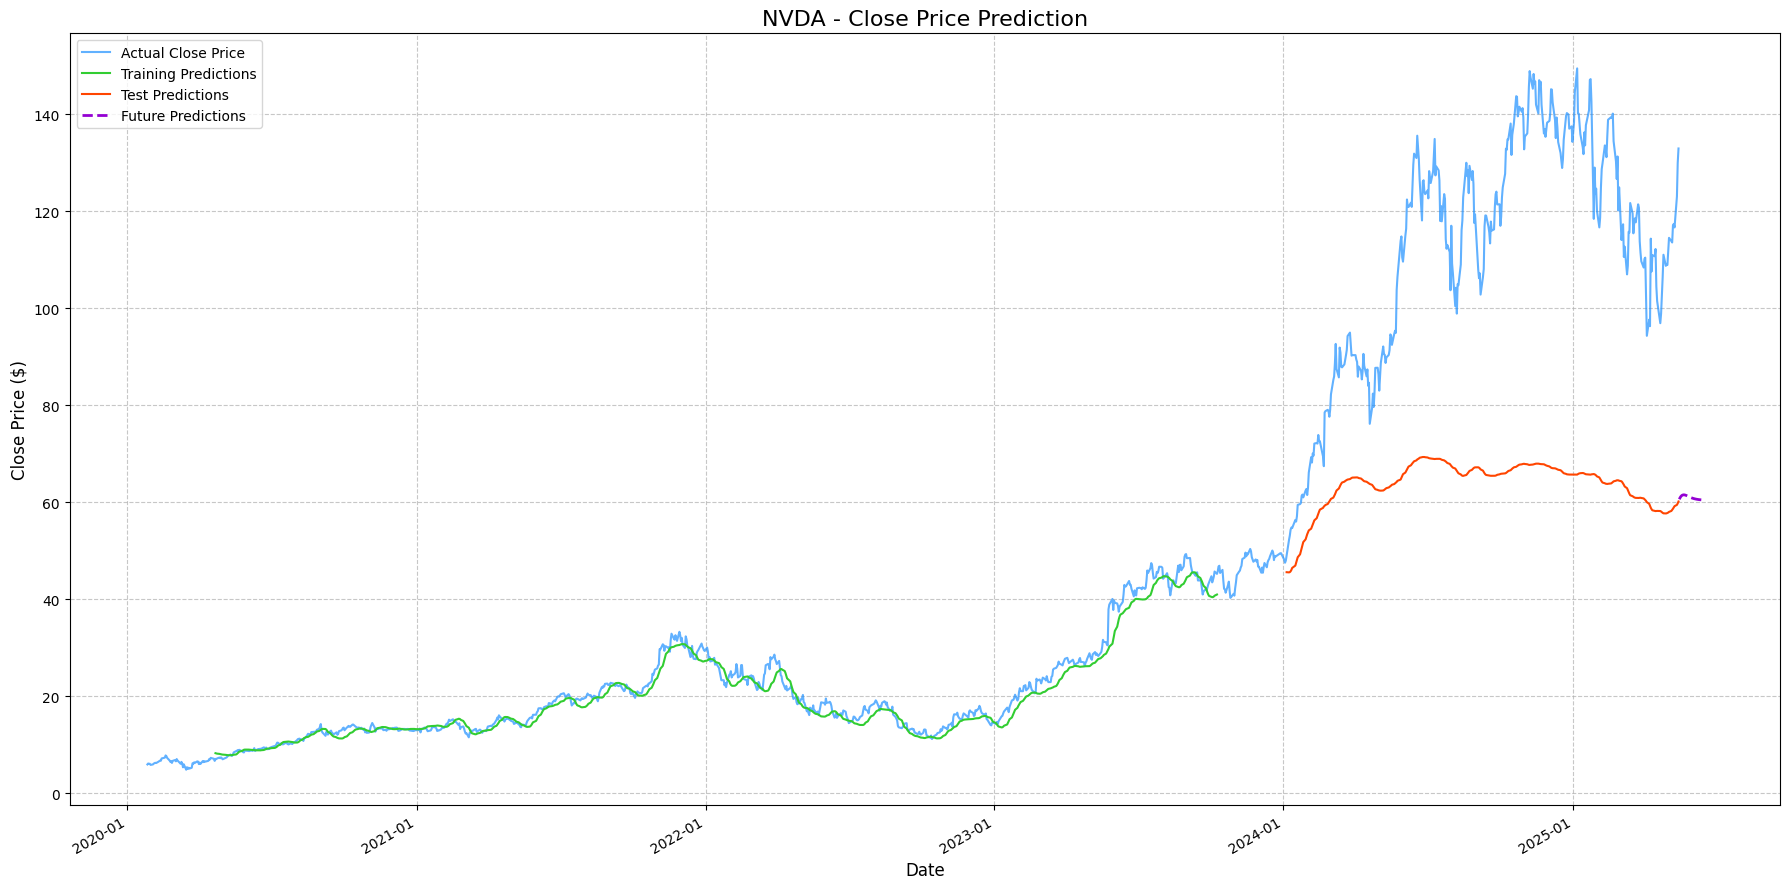

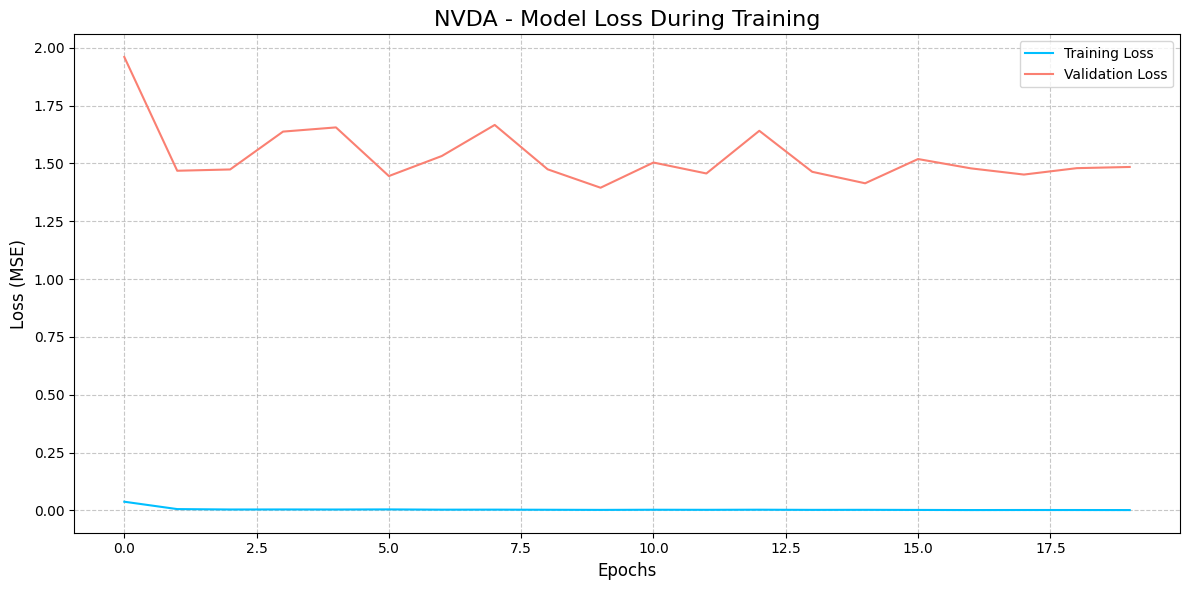

Model saved as 'NVDA_lstm_model.keras'
Combined historical and future predictions saved to 'NVDA_historical_and_future.csv'

==== Prediction Complete: Final Metrics for NVDA ====
train_rmse: 1.8361
test_rmse: 52.4821
train_mae: 1.3165
test_mae: 48.2124
train_r2: 0.9654
test_r2: -3.7361

Sample of future predictions for NVDA (30 days):
             Predicted_Close
Future_Date                 
2025-05-15         60.626762
2025-05-16         60.949230
2025-05-17         61.199631
2025-05-18         61.373264
2025-05-19         61.479504
...
             Predicted_Close
Future_Date                 
2025-06-09         60.552570
2025-06-10         60.533272
2025-06-11         60.516277
2025-06-12         60.501339
2025-06-13         60.488186


In [71]:
# Example usage with the processed dataframe
if __name__ == "__main__":
    # --- Configuration: Update stock ticker, features, and paths ---
    GLOBAL_STOCK_TICKER = "NVDA"  # Example: Change to your desired stock ticker
    GLOBAL_STOCK_TITLE = f"{GLOBAL_STOCK_TICKER} Stock Analysis & LSTM Prediction"

    # Define the list of features to use for the LSTM model.
    # IMPORTANT: Ensure these features are present in your 'merged_dataset_TICKER.csv'.
    # Also, consider the nature of these features:
    #   - Price/Volume based (Open, High, Low, Close, Volume, MAs, RSI, Volatility): These change daily.
    #   - Fundamental (revenue, netIncome, eps): These are typically reported quarterly/annually.
    #     Your EDA script must handle how these are propagated to daily data (e.g., forward-fill).
    #   - Ratios (PE_ratio, price_to_sales): These depend on current price and historical fundamentals.
    FEATURES_TO_USE = [
        'Open', 'High', 'Low', 'Close', 'Volume', # Core stock data
        'MA_50', 'MA_200',                       # Moving Averages
        'RSI',                                   # Relative Strength Index
        'volatility_20d',                        # Historical Volatility
        'volume_ma_5',                           # Volume Moving Average
        # Optional: Add fundamental data if properly preprocessed to daily frequency
        # 'revenue', 'netIncome', 'eps', 
        # 'grossProfitRatio', 'operatingIncomeRatio', 'netIncomeRatio',
        # 'PE_ratio', 'price_to_sales',
        # 'days_since_financial_update', 
        # 'weightedAverageShsOutDil', # Needed for some ratios if calculated on the fly
    ]
    # Ensure 'Close' (or your target_col) is in FEATURES_TO_USE if it's not added automatically.
    # The prepare_lstm_data function will add the target_col if it's missing from FEATURES_TO_USE but present in the DataFrame.


    # Path to the merged dataset (expected output from a previous EDA/preprocessing script)
    merged_data_path = f"{GLOBAL_STOCK_TICKER}_merged_dataset_{GLOBAL_STOCK_TICKER}.csv"

    print(f"Attempting to load processed data for LSTM prediction from: {merged_data_path}")

    enhanced_df = None
    try:
        # Load the data, ensuring 'date' column is parsed as DatetimeIndex
        enhanced_df = pd.read_csv(
            merged_data_path,
            index_col='date',    # Set 'date' column as index
            parse_dates=True     # Parse the index as datetime objects
        )
        
        # Validate that the index is indeed a DatetimeIndex
        if not isinstance(enhanced_df.index, pd.DatetimeIndex):
            raise ValueError("Index is not DatetimeIndex after loading. Please check 'date' column in CSV.")
        
        print(f"Data loaded successfully. Shape: {enhanced_df.shape}")
        print(f"Columns available: {enhanced_df.columns.tolist()}")
        print(f"Date range: {enhanced_df.index.min()} to {enhanced_df.index.max()}")

    except FileNotFoundError:
        print(f"Error: Merged data file not found at {merged_data_path}.")
        print("Please ensure you have run the EDA/preprocessing script first to generate this file.")
    except Exception as e:
        print(f"An error occurred while loading the merged data: {e}")
        import traceback
        traceback.print_exc()

    # Proceed only if data loading was successful
    if enhanced_df is not None and not enhanced_df.empty:
        print("\nProcessed data loaded successfully. Running LSTM prediction.")

        # Run LSTM prediction with future forecasting
        # Adjust sequence_length, epochs, batch_size, predict_days as needed
        model, metrics, test_preds, future_preds, future_dates_out = predict_lstm(
            enhanced_df,
            target_col='Close',       # Column to predict
            sequence_length=60,       # Number of past days' data to use for predicting the next day
            epochs=75,                # Maximum training epochs (EarlyStopping will likely stop it sooner)
            batch_size=32,            # Number of samples per gradient update
            predict_days=30           # Number of future days to predict
        )

        if metrics is not None:
            print(f"\n==== Prediction Complete: Final Metrics for {GLOBAL_STOCK_TICKER} ====")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.4f}")
        
        if future_preds is not None and future_dates_out is not None:
            print(f"\nSample of future predictions for {GLOBAL_STOCK_TICKER} ({len(future_preds)} days):")
            future_output_df = pd.DataFrame(future_preds, index=pd.to_datetime(future_dates_out), columns=[f'Predicted_Close'])
            future_output_df.index.name = 'Future_Date'
            print(future_output_df.head())
            if len(future_preds) > 5:
                print("...")
                print(future_output_df.tail())

    else:
        print("Could not proceed with LSTM prediction due to data loading issues or empty DataFrame.")

